In [1]:
import numpy as np
import math
import pickle
import copy
import json
import os

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable


In [10]:
map_name ="com1building"
aug_map = pickle.load(open("./logs/%s.pkl" % (map_name), "rb")) 
ROBOT_SIZE = 0.2552
if "com" in map_name:
    width = 2500
    height = 983
    resolution = 0.02
else:
    width = 200
    height = 200
    resolution = 0.05

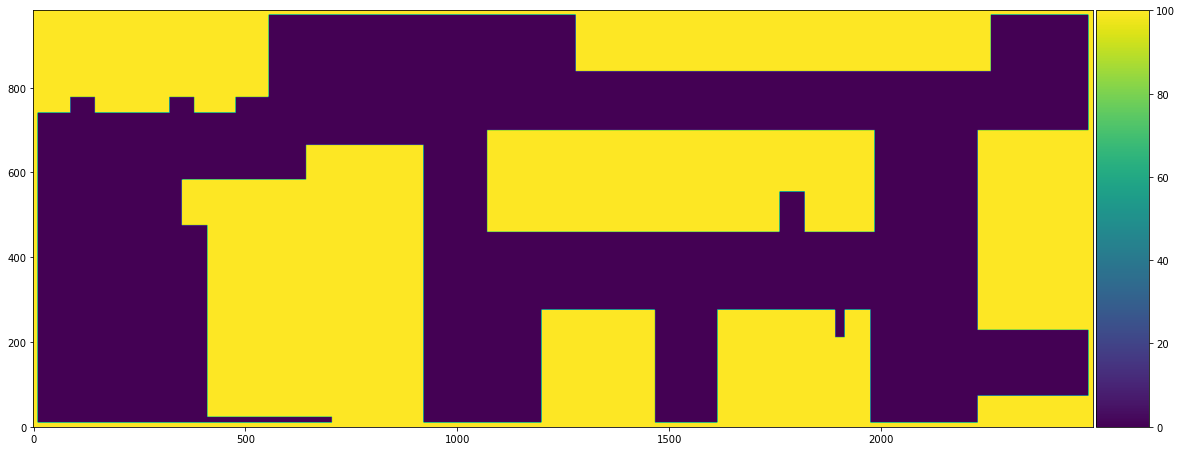

In [13]:
map_base = np.array(map).reshape(height, width)
fig, ax = plt.subplots(figsize=(20, 20))
im = ax.imshow(aug_map.T, origin='lower')
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im, cax=cax, orientation='vertical')


In [3]:

class Evaluator(object):
    def __init__(self, filename, aug_map, start, goal, res):
        self.filename = filename
        self.aug_map = aug_map
        self.start = np.array(start)
        self.goal = np.array(goal)
        self.gen_policy()
        self.res = res

    def gen_policy(self):
        self.policy = np.genfromtxt(self.filename)

    def distance_function(self, v):
        return v * 0.5

    def simulate(self, actions):
        pose = np.array(self.start)

        distance = 0
        for v, w in actions:
            pose = self.motion_predict(pose[0], pose[1], pose[2], v, w, self.aug_map)
            distance += self.distance_function(v)
            if pose is None:
                break

        if pose is None:
            print("Collision!")
            return -1
        elif np.sum((pose[:2] - self.goal) ** 2) < 0.09:
            # print('Reach the goal, distance traveled: {}'.format(distance))
            return distance
        else:
            pass

    def evaluate(self):
        actions = self.policy
        distance = self.simulate(actions)
        return 1 / distance

    def motion_predict(self, x, y, theta, v, w, aug_map, dt=0.5, frequency=10):
        """
        This function predicts the next state when transitioning from the current state (x,y,theta) by action (v,w).
        Returns None if the motion results in collision.
        """
        num_steps = int(dt * frequency)
        dx = 0
        dy = 0
        for i in range(num_steps):
            if w != 0:
                dx = -v / w * np.sin(theta) + v / w * np.sin(theta + w / frequency)
                dy = v / w * np.cos(theta) - v / w * np.cos(theta + w / frequency)
            else:
                dx = v * np.cos(theta) / frequency
                dy = v * np.sin(theta) / frequency
            x += dx
            y += dy

            x_index = int(math.floor(x / self.res))
            y_index = int(math.floor(y / self.res))
            if (
                x_index >= aug_map.shape[0]
                or x <= 0
                or y_index >= aug_map.shape[1]
                or y <= 0
            ):
                return None
            if aug_map[x_index, y_index] != 0:
                return None
            theta += w / frequency
            if theta >= np.pi * 2:
                theta = theta / (np.pi * 2) * 360
                theta = theta % 360 / 360 * np.pi * 2

        return x, y, theta


class DiscreteEvaluator(Evaluator):
    def gen_policy(self):
        self.policy = np.genfromtxt(self.filename)
        self.policy = self.generate_action_sequence_discrete(self.policy)

    def distance_function(self, v):
        return 1 * v

    def generate_action_sequence_discrete(self, actions):
        controls = []
        for act in actions:
            act = [act[0], act[1] * np.pi / 2]
            controls += [act, act]

        return controls


class MDPEvaluator(Evaluator):
    def gen_policy(self):
        try:
            with open(self.filename, "r") as fin:
                self.policy = json.load(fin)
        except:
            raise ValueError("incorrect policy file")

    def get_action(self, pose):
        position = copy.deepcopy(pose)
        position[0] = round(position[0])
        position[1] = round(position[1])
        position[2] = round(position[2] / (np.pi / 2)) % 4

        position = [str(int(s)) for s in position]
        position = ",".join(position)
        act = copy.deepcopy(self.policy[position])

        if act[0] != 0:
            r = np.random.rand()
            if r < 0.9:
                pass
            elif r < 0.95:
                act = [np.pi / 2, 1]
            else:
                act = [np.pi / 2, -1]

        act[1] = act[1] * np.pi / 2

        return [act, act]

    def simulate(self):
        pose = copy.deepcopy(self.start)
        steps = 0

        while True:
            action = self.get_action(pose)
            for act in action:
                pose = self.motion_predict(
                    pose[0], pose[1], pose[2], act[0], act[1], self.aug_map
                )
                if pose is None:
                    break
                pose = np.array(pose)

            steps += 1

            if pose is None or steps > 100:
                return -1
            elif np.sum((pose[:2] - np.array(self.goal)) ** 2) < 0.09:
                return steps
            else:
                pass

    def evaluate(self):
        records = []
        N = 100
        for i in range(N):
            step = self.simulate()
            spl = float(step > 0) / step
            records.append(spl)

        return np.sum(records) / N

In [4]:
args = {
    "goal_file": "../../../files/goals.json",
    "map_dir": "./logs",
    "control_dir":"./Controls",
}

In [5]:
with open(args["goal_file"], "r") as _f:
    goal_dict = json.load(_f)
    
scores = {}
for map_name in ["map1", "map2", "map3", "map4", "com1building"]:
    goals = goal_dict["%s.png" % map_name]
    map_path = os.path.join(args["map_dir"], map_name + ".pkl")
    res = 0.02 if map_name == "com1building" else 0.05
    with open(map_path, "rb") as fin:
        loaded_aug_map = pickle.load(fin, encoding='latin1')
    for task in ["DSPA"]: #["DSDA", "CSDA", "DSPA"]:
        for goal in goals:
            filename = (
                task + "_" + map_name + "_" + str(goal[0]) + "_" + str(goal[1])
            )
            plan_path = os.path.join(args["control_dir"], filename)
            try:
                if task == "DSDA":
                    plan_path = plan_path + ".txt"
                    evaluator = DiscreteEvaluator(
                        plan_path, loaded_aug_map, (1, 1, 0), goal, res
                    )
                elif task == "CSDA":
                    plan_path = plan_path + ".txt"
                    evaluator = Evaluator(
                        plan_path, loaded_aug_map, (1, 1, 0), goal, res
                    )
                else:
                    plan_path = plan_path + ".json"
                    evaluator = MDPEvaluator(
                        plan_path, loaded_aug_map, (1, 1, 0), goal, res
                    )
                spl = evaluator.evaluate()
                print("%s score %s" % (filename, spl))
                scores[filename] = spl
            except Exception as e:
                print("Failed to evaluate %s: %s" % (filename, e))
print(scores)

DSPA_map1_3_5 score 0.10380389463477696
DSPA_map1_8_8 score 0.013983175407324014
DSPA_map1_7_6 score 0.04617162445684118
DSPA_map2_5_5 score 0.0008141107613614007
DSPA_map2_9_8 score 0.008666666666666666
DSPA_map2_3_3 score 0.003066500893201792
DSPA_map3_9_7 score 0.01584915428668289
DSPA_map3_4_5 score 0.07551003163503162
DSPA_map3_5_7 score 0.0007763157894736841
DSPA_map4_5_4 score 0.03808170995670995
DSPA_map4_9_9 score 0.04305917016248004
DSPA_map4_8_3 score 0.03705722559219009
DSPA_com1building_4_8 score 0.07590304282061247
DSPA_com1building_31_4 score 0.012981266845958107
DSPA_com1building_49_3 score 0.008996159632274512
DSPA_com1building_30_16 score 0.013402648896041387
DSPA_com1building_20_1 score 0.01517556905025866
DSPA_com1building_48_18 score 0.010502802180916539
{'DSPA_map1_3_5': 0.10380389463477696, 'DSPA_map1_8_8': 0.013983175407324014, 'DSPA_map1_7_6': 0.04617162445684118, 'DSPA_map2_5_5': 0.0008141107613614007, 'DSPA_map2_9_8': 0.008666666666666666, 'DSPA_map2_3_3': 0.

In [ ]:
DSPA_map1_3_5 score 0.09755494505494502
DSPA_map1_8_8 score 0.013164752344318909
DSPA_map1_7_6 score 0.05123111872647476
DSPA_map2_5_5 score 0.0004083333333333333
DSPA_map2_9_8 score 0.006555555555555557
DSPA_map2_3_3 score 0.0017142857142857142
DSPA_map3_9_7 score 0.012672071483055462
DSPA_map3_4_5 score 0.07744913419913421
DSPA_map3_5_7 score 0.0030200336149992903
DSPA_map4_5_4 score 0.03900036075036075
DSPA_map4_9_9 score 0.04007545995306797
DSPA_map4_8_3 score 0.03989432922321043
DSPA_com1building_4_8 score 0.0736244504979025
DSPA_com1building_31_4 score 0.009049134996946645
DSPA_com1building_49_3 score 0.00582102280559259
DSPA_com1building_30_16 score 0.011321486312869479
DSPA_com1building_20_1 score 0.011245554593789129
DSPA_com1building_48_18 score 0.005068890777592361

In [ ]:
DSPA_map1_3_5 score 0.10194719169719167
DSPA_map1_8_8 score 0.018199308431506574
DSPA_map1_7_6 score 0.0455075608086444
DSPA_map2_5_5 score 0.0014115508485073702
DSPA_map2_9_8 score 0.008555555555555556
DSPA_map2_3_3 score 0.003154932786511734
DSPA_map3_9_7 score 0.018928906140079502
DSPA_map3_4_5 score 0.07630169830169829
DSPA_map3_5_7 score 0.0027796793774718122
DSPA_map4_5_4 score 0.039373071373071375
DSPA_map4_9_9 score 0.04441745106745536
DSPA_map4_8_3 score 0.03859453442138863
DSPA_com1building_4_8 score 0.07474149195317925
DSPA_com1building_31_4 score 0.012469528778386536

In [ ]:
map_base = np.array(map).reshape(world_height, world_width)
fig, ax = plt.subplots(figsize=(10, 10))
im = ax.imshow(loaded_aug_map, origin='lower')
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im, cax=cax, orientation='vertical')
